<!-- 这里是关于biac compensation方法的使用样例。您可以按照此样例将bias compensation应用于您的代码中，可以在完全不增加额外时间和空间复杂度的前提下，极大地降低量化层的输出误差，从而有效提升量化模型在低位宽量化条件下的任务性能。 -->
Here is a demo of the bias compensation method. You can follow this example to apply bias compensation to your code. With no additional time and space complexity, it can greatly reduce the output error of the quantization layer, thereby effectively improving the task performance of the quantized model under low bit width quantization conditions.

First, we need to select a layer for quantization.
Here, we select a layer of ViT-T model.
In addition to selecting a layer of model, you can also choose blocks of model for compensation.

In [93]:
import os
import torch
import timm
from torch import nn

name = 'vit_tiny_patch16_224'
vit = timm.create_model(name, pretrained=True)
layer = vit.blocks[0].attn.qkv

Next, we can apply quantizer and BC module to the layer.
We utilize the quantization API to apply bias compensation to the quantized layer. 
The quantization API referenced form AutoQNN.
If there is a post quantizer for the quantized layer, you can use the nn.Sequential module to combine the post quantizer and bias compensation module.

In [98]:
from bias_compensation.quantizers.BiasCompensation import BiasCompensation
from bias_compensation.quantizers.fixedpointQ import FixedPointQunatization
from bias_compensation.quantize.quantize import quantize_module_act,quantize_module_weight
import copy

layer = vit.blocks[0].attn.qkv # layer or block that you want to compensation for
q_layer = copy.deepcopy(layer)
channel_size = 576 # vector size for bc vector, which should be completely divided by match the output size
channel_axis = (-1,) # the dims of output tensor
# Obtain bc object, which is quantizer
bc = BiasCompensation(channel_size=channel_size, channel_axis=channel_axis)
quantizer = FixedPointQunatization(bitwidth=4)
# Apply this quantizer to the layer output
quantize_module_weight(q_layer,quantizer,'weight',PTQ=True)
quantize_module_act(q_layer,bc,act_id=0,pre=False)
print(q_layer)

Linear(
  in_features=192, out_features=576, bias=True
  (quantized_weight_module): FixedPointQunatization()
  (quantized_act0_post_module): BiasCompensation()
)


In [97]:
import bias-compensation

SyntaxError: invalid syntax (3302728055.py, line 1)

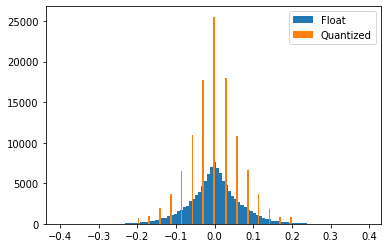

In [64]:
import matplotlib.pyplot as plt
_ = plt.hist(layer.weight.data.cpu().flatten(),bins=100,label="Float")
_ = plt.hist(q_layer.weight.data.cpu().flatten(),bins=100,label="Quantized")
plt.legend()

To set different quantizers for the quantized layer, you can follow the steps below.

In [35]:

q_layer.quantized_weight_module = nn.Identity()
q_layer.quantized_act0_post_module = nn.Identity()
print(q_layer)

Linear(
  in_features=192, out_features=576, bias=True
  (quantized_weight_module): Identity()
  (quantized_act0_post_module): Identity()
)


To align the quantized and float layers using our BC approach, please follow these instructions.

In [36]:
q_layer.quantized_weight_module = quantizer
q_layer.quantized_act0_post_module = bc
calibra_data = torch.rand(1,1024,192)
layer.eval()
with torch.no_grad():
    float_output = layer(calibra_data)
    quantized_output = q_layer(calibra_data)
    bc.update(float_output,quantized_output)

Finally, we evaluate the output error with and without BC to assess its impact.

error without bc:  36148.8359375
error with bc:  17170.2265625


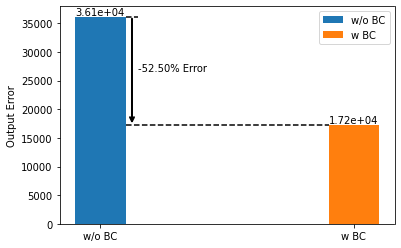

In [92]:
with torch.no_grad():
    quantized_output_bc = q_layer(calibra_data)
error1 = torch.sum(torch.abs(float_output-quantized_output))
error2 = torch.sum(torch.abs(float_output-quantized_output_bc))
print("error without bc: ",error1.item())
print("error with bc: ",error2.item())
plt.bar([1],[error1.item()],width=0.2,label="w/o BC")
plt.bar([2],[error2.item()],width=0.2,label="w BC")
plt.plot([1.1,1.9],[error2.item(),error2.item()],'k--')
plt.plot([1.1,1.15],[error1.item(),error1.item()],'k--')
plt.annotate('', xy=(1.125, error1.item()), xytext=(1.125, error2.item()),
             arrowprops=dict(arrowstyle='<-', linewidth=2, color='k'))
plt.annotate("-%.2f%% Error"%((error1.item()-error2.item())/error1.item()*100), xy=(1.15, (error1.item()+error2.item())/2),color='k')
plt.annotate('%.2e'%(error1.item()), xy=(0.9, error1.item()*1.006),color='k')
plt.annotate('%.2e'%(error2.item()), xy=(1.9, error2.item()*1.02),color='k')
plt.legend()
plt.ylabel("Output Error")
_ = plt.xticks([1,2],["w/o BC","w BC"])